# **Stock XGBoost Model**

In [23]:
!pip install shap

In [24]:
import shap
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [25]:
stock = pd.read_csv('stockffads.csv')

In [26]:
X = stock.drop(['Adj Close', 'Close', 'Date'], axis=1)  # Features
y = stock['Adj Close']  # Target variable

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [28]:
base_model = xgb.XGBRegressor()

In [29]:
base_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
y_pred = base_model.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['Predicted'])
df_pred

,Predicted
0,161.210281
1,324.560516
2,236.250107
3,279.034302
4,55.637611
...,...
491,249.030685
492,153.677170
493,22.916706
494,306.160797


In [31]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 9.092443232928236


In [32]:
import numpy as np

# Get feature importances from the trained model
feature_importances = base_model.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances * 100})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
2,Low,56.651253
1,High,41.648106
8,Yest_Close,0.934424
0,Open,0.659613
12,EMA_12,0.055105
9,stock_return,0.011947
11,SMA_50,0.011578
13,EMA_26,0.005860
10,SMA_20,0.005155
15,RSI,0.004697


In [33]:
# Select the top k significant features
k = 10  # Number of significant features to select
significant_features = feature_importance_df.head(k)['Feature'].values

# Filter the data to keep only the significant features
X_significant_training = X_train[significant_features]
X_significant_testing = X_test[significant_features]

In [34]:
# Retrain the model using only the significant features
model_retrained = xgb.XGBRegressor()
model_retrained.fit(X_significant_training, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [35]:
y_pred_retrained = model_retrained.predict(X_significant_testing)
df_pred_retrained = pd.DataFrame(y_pred_retrained, columns=['Optimized Predicted'])
df_pred_retrained

,Optimized Predicted
0,162.802460
1,324.962921
2,237.481995
3,279.453217
4,53.747421
...,...
491,248.833679
492,153.543640
493,22.943457
494,304.303741


In [36]:
mse = mean_squared_error(y_test, y_pred_retrained)
print("Mean Squared Error:", mse)

Mean Squared Error: 8.41117394859268


In [37]:
df_test = pd.DataFrame(y_test, columns=['Adj Close'])
df_test.reset_index(drop=True, inplace=True)
df_test

,Adj Close
0,161.199997
1,319.503326
2,236.473328
3,273.843323
4,54.085999
...,...
491,251.943329
492,153.766663
493,22.933332
494,307.333344


In [38]:
# Concatenate the dataframes horizontally
merged_df = pd.concat([df_test, df_pred, df_pred_retrained], axis=1)
merged_df

,Adj Close,Predicted,Optimized Predicted
0,161.199997,161.210281,162.802460
1,319.503326,324.560516,324.962921
2,236.473328,236.250107,237.481995
3,273.843323,279.034302,279.453217
4,54.085999,55.637611,53.747421
...,...,...,...
491,251.943329,249.030685,248.833679
492,153.766663,153.677170,153.543640
493,22.933332,22.916706,22.943457
494,307.333344,306.160797,304.303741


In [42]:
'''# Plot the line chart
plt.figure(figsize=(25, 10))

plt.plot(merged_df['Adj Close'], color= 'red', label='Original Close Price',)
plt.plot(merged_df['Predicted'], color='blue', label='Predicted Close Price')
plt.plot(merged_df['Optimized Predicted'], color='green', label='Optimized Predicted Close Price')

# Set the labels and title
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()'''

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = merged_df.index,
    y = merged_df['Adj Close'],
    name = 'Original Close Price',
    line = dict(color='red')
))

fig.add_trace(go.Scatter(
    x = merged_df.index, 
    y = merged_df['Predicted'],
    name = 'Predicted Close Price',
    line = dict(color='blue')
))

fig.add_trace(go.Scatter(
    x = merged_df.index,
    y = merged_df['Optimized Predicted'], 
    name = 'Optimized Predicted Close Price',
    line = dict(color='green')
))

fig.update_layout(
    title = 'Actual vs Predicted Close Price',
    xaxis_title = 'Date',
    yaxis_title = 'Close Price',
    legend_title = 'Legend'  
)

fig.show()

## **SHAP Analysis**

c:\Users\aksha\DSE_1\venv\lib\site-packages\xgboost\core.py:160: UserWarning:

[23:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



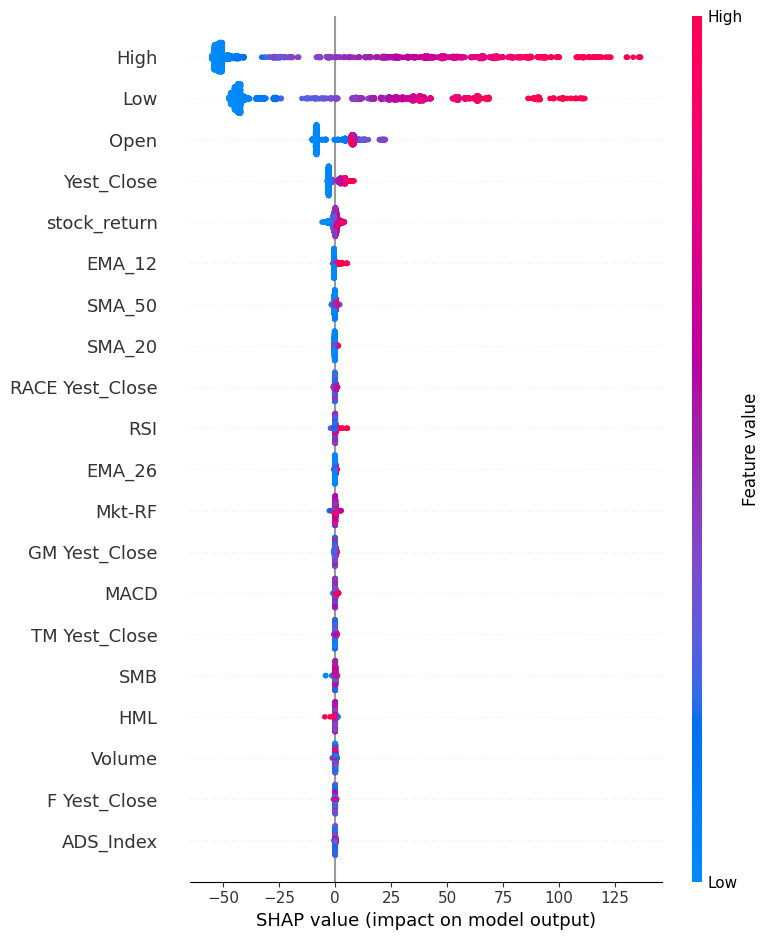

In [46]:
# Create an explainer object
explainer = shap.Explainer(base_model, X)
# Calculate SHAP values
shap_values = explainer.shap_values(X)
# Plot summary plot
shap.summary_plot(shap_values, X)

c:\Users\aksha\DSE_1\venv\lib\site-packages\xgboost\core.py:160: UserWarning:

[23:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



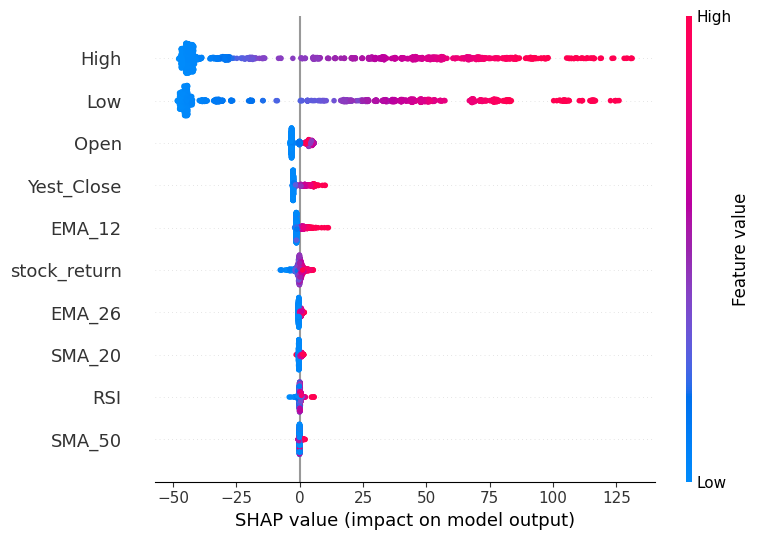

In [47]:
# Create an explainer object
explainer_retrained = shap.Explainer(model_retrained, X_significant_training)
# Calculate SHAP values
shap_values_retrained = explainer_retrained.shap_values(X_significant_training)
# Plot summary plot
shap.summary_plot(shap_values_retrained, X_significant_training)